In [3]:
import csv
import os

import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from dataManager import DataManager
from maskPredictor import MaskPredictor


def datagen(video_path,nn_weights_path, batch_size=1, output_length=30):
    """Data generator: takes video and weights path and produce a tuple: masks and source """
    data_mngr = DataManager(video_path)
    frame_generator = data_mngr.get_frames_gen(batch_size=batch_size,
                                               num=30*output_length*60)
    nn_model = MaskPredictor(nn_weights_path)
    masks_generator = nn_model.get_mask_generator(frame_generator)

    areas = []

    for i, (mask, frame, source) in tqdm(enumerate(masks_generator)):
        # # contours
        contours = source.copy()
        mask = cv2.resize(mask, (contours.shape[1], contours.shape[0]))
        # mask = cv2.threshold(np.uint8(mask[:,:]*255), 210, 255, cv2.THRESH_BINARY)[1]
        # kernel = np.ones((9, 9), np.uint8)
        # mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contours, cnts, -1, (0, 255, 0), 5)
        print('final', mask)
        data = {'orig': source,
                'mask': mask,
                'contours':  contours}

        yield data

def visualizer(generator, savepath, output_length=0.5, fps=15, bitrate=1800):
    fig = plt.figure(constrained_layout=True, figsize=(18, 12))
    gs = fig.add_gridspec(4, 4)
    ax_orig = fig.add_subplot(gs[0:2, :2])
    ax_orig.set_title('Исходное изображение', fontsize=12)
    ax_masks = fig.add_subplot(gs[2:, 0:2])
    ax_masks.set_title('Маска', fontsize=12)
    ax_contours = fig.add_subplot(gs[:2, 2:])
    ax_contours.set_title('Рассчитанные контуры', fontsize=12)
    ax_contours.axis('off')
    ax_orig.axis('off')
    ax_masks.axis('off')


    def updateData(data):
        keys = ['orig', 'mask',  'contours']
        orig, mask,   contours = [data[key] for key in keys]
        # original
        ax_orig.clear()
        ax_orig.set_title('Исходное изображение', fontsize=12)
        ax_orig.imshow(orig, aspect='auto')
        ax_orig.axis('off')

        # masks
        ax_masks.clear()
        ax_masks.set_title('Маска', fontsize=12)
        ax_masks.imshow(mask, cmap='gray', aspect='auto')
        ax_masks.axis('off')

        # # contours
        ax_contours.clear()
        ax_contours.set_title('Рассчитанные контуры', fontsize=12)
        ax_contours.imshow(contours, aspect='auto')
        ax_contours.axis('off')

    simulation = animation.FuncAnimation(fig, updateData, frames=generator, save_count=30*output_length*60)

    writer = animation.writers['ffmpeg'](fps=fps, bitrate=10000)
    simulation.save(savepath, writer=writer)


def main():
    if not os.path.exists('./results'):
        os.makedirs('./results')

    if not os.path.exists('./weights'):
        os.makedirs('./weights')

    if not os.path.exists('../data'):
        os.makedirs('../data')

    generator = datagen('/Users/s70c3/Projects/Nornikel-project/NornilFroathOpticalFlow/data/90_1_7.mp4', '/Users/s70c3/Projects/Nornikel-project/NornilFroathOpticalFlow/weights/unetplusplus_weights.pt')
    visualizer(generator, './results/visualization.mp4', fps=15, output_length=0.01)

    return 0

0it [00:00, ?it/s]

207 28 [102  57  62  60  45  35  41  38  33  36  35  33  30  29  30  30  30  30
  31  30  31  32  31  30  30  31  31  31  32  31  30  29  29  29  29  30
  30  28  30  30  31  33  33  32  33  36  35  33  34  35  37  36  36  36
  34  33  35  39  44  45  49  52  53  49  51  52  49  58  59  60  70  77
  83  97 102 113 125 122 129 166 194 203 207 191 188 167 157 146 140 148
 126 134 160 179 190 168 171 132 112 105 101 100 102 109 106 104 106 107
 106 109 105 108 115 112 111 108 103 102 106 105 106 107 110 107 107 116
 120 120 131 141 120 112 116 127 135 137 147 149 146 112 105 102 102 107
 111 124 121 120 118 116 108 113 113 116 112 105 105 107 114 117 118 115
 115 119 119 118 120 108 114 113 113 121 120 115 120 117 119 120 105  99
 102 108  91  74  66  64  66  69  73  75  83  91  91  93  97  96  83  80
  90  88  89  93  84  76  63  55  54  46  45  46  48  44  43  44  41  42
  45  43  38  36  35  35  34  34  31  32  31  30  29  30  29  29  28  28
  29  30  31  31  31  31  31  30  32  33  35

1it [00:01,  1.01s/it]

191 28 [102  57  62  61  45  35  41  38  33  35  35  33  30  30  30  31  30  30
  30  30  30  31  31  30  30  31  30  30  30  29  29  28  29  29  29  30
  30  29  30  28  30  31  32  31  31  35  35  34  35  35  37  36  36  36
  35  33  34  36  41  44  48  53  55  54  60  62  60  63  55  54  61  66
  74  82  89 114 124 126 129 146 172 191 185 174 173 144 136 131 133 133
 119 122 108 125 130 126 136 123 119 103 105 100  96  93  92  81  82  79
  79  77  74  74  79  84  79  77  78  75  80  84  83  84  83  88  96 107
 116 115 127 131 122 125 128 120 111  97 101 112 120 120 135 131 137 124
 120 115 115 110 107 107  92  84  76  70  72  69  67  68  73  79  79  77
  75  76  76  78  81  72  73  67  64  59  56  54  55  60  60  58  58  62
  62  62  61  60  64  72  71  64  59  55  59  65  63  62  65  70  69  65
  82  94  92  88  81  69  57  52  52  48  47  46  46  44  42  40  37  38
  42  42  38  36  35  36  35  34  31  33  32  32  31  31  30  30  29  29
  29  29  30  30  30  30  30  30  31  33  34

2it [00:01,  1.02it/s]

144 28 [102  57  62  60  45  34  41  38  33  35  35  32  30  29  30  30  30  30
  30  30  31  32  32  31  31  32  31  31  32  30  30  29  29  29  29  30
  29  28  29  28  30  31  32  31  33  36  35  34  35  35  37  36  36  36
  36  33  33  35  41  45  50  54  58  63  70  70  69  65  64  74  75  75
  83  91 100 112 120 135 133 124 121 116 135 136 127 122 132 140 144 124
 119 117 105 107 100 111 110 107  93  77  70  61  53  50  52  50  64  70
  61  56  55  53  58  63  62  66  70  75  79  88  87  88  97 102  90  79
  75  73  74  73  73  75  76  73  74  86  83  80  91  98  97  93  91  94
  82  80  79  76  89  94  87  83  81  83  82  74  72  66  68  71  67  58
  60  59  59  60  63  63  60  59  57  50  48  47  49  52  55  54  49  47
  48  52  54  60  61  61  63  62  59  60  60  62  67  70  76  87  87  93
 109 115 119 127 113 102  93  73  73  62  53  49  48  45  43  42  41  43
  44  43  39  37  37  37  35  34  32  33  32  31  30  30  30  30  29  29
  29  29  30  31  30  30  31  31  33  34  35

3it [00:02,  1.15it/s]

184 28 [102  57  62  61  45  34  41  38  33  35  35  33  30  30  30  30  30  30
  31  30  31  31  31  30  30  31  30  30  31  30  30  29  29  29  29  30
  29  28  29  28  30  31  32  30  32  35  35  34  35  36  38  36  36  37
  38  37  39  44  51  58  68  81  93 121 125 117  99 103 124 144 158 164
 184 164 162 138 133 114 107  99  99 104 101  93  80  76  78  73  65  60
  57  55  58  58  53  51  54  60  57  57  57  55  62  74  77  73  83  95
  88  79  81  80  79  86  77  76  86  87  85  86  83  90  99 103 107 110
 114 105  99 101 105 100 101  96  96  99 102 106 109 120 124 122 124 125
 124 125 126 123 120 122 116 116 117 115 123 114 105 106 111 117 122 113
 111  99 108 118 120 122 119 119 118 112 110 111 107 108 109 108 107 109
 114 110 113 118 109 106 103  86  79  80  77  71  74  75  79  89  88  92
 106 108 107 105  92  81  67  62  58  49  47  44  46  49  46  44  41  40
  43  41  37  35  33  34  34  34  31  33  32  32  31  31  31  31  30  29
  29  29  31  31  31  30  31  30  33  35  36

4it [00:03,  1.11it/s]

129 28 [102  57  62  60  45  35  41  38  33  35  35  32  30  29  30  30  30  30
  31  30  31  31  31  30  30  31  30  30  30  29  29  29  29  29  28  30
  29  29  30  29  30  30  31  31  33  36  35  33  33  34  36  35  35  35
  34  33  35  38  43  43  48  54  50  45  49  58  57  61  63  64  67  71
  74  74  77  85  81  80  74  65  71  78  90 107 111 103  90  80  81  85
  85  81  89  97  91  85  75  70  70  71  92  99 110 115 125 129 122 112
 113  96  96 102  98  97  91  87  88  80  81  84  81  81  90  87  85  94
  93  93  85  79  86  92  90  86  79  73  73  76  81  81  82  85  87  87
  87  86  84  80  81  84  81  82  87  82  83  97 107 109 114 122 117 113
 107 104 105 110 104 100  92  82  82  73  70  68  63  64  70  69  71  79
  74  70  78  74  69  74  70  57  58  61  60  67  68  64  66  75  75  78
  93 113 119 126 113  90  78  67  60  50  48  45  45  42  42  43  39  39
  41  41  38  36  35  35  34  33  31  32  32  31  30  30  30  29  28  28
  28  29  30  30  30  30  31  30  32  34  35

5it [00:04,  1.16it/s]

124 28 [102  57  62  60  45  35  41  38  33  35  35  33  30  29  30  30  29  29
  30  30  30  31  31  30  30  31  30  30  31  30  30  29  29  29  29  30
  29  28  29  28  30  31  32  31  33  35  35  34  35  36  37  35  35  37
  36  32  35  43  48  49  54  59  63  63  67  72  69  78  78  77  71  61
  58  64  64  57  52  53  57  58  60  62  60  56  55  56  58  57  57  55
  57  64  72  84  80  64  62  61  63  70  75  67  68  72  70  64  59  55
  56  60  65  67  62  62  63  69  76  86  96 101 100 102 105 108 109 109
 106 114 111 102 102  90  83  85  81  70  67  65  65  57  53  51  50  48
  47  47  49  52  51  49  48  47  49  49  47  47  52  53  49  48  48  52
  56  59  55  59  67  66  60  63  66  59  57  52  55  58  55  52  54  55
  57  58  60  56  56  61  61  54  55  56  55  56  56  58  60  69  77  88
 104 120 117 124 110  93  83  65  54  46  42  42  43  39  41  42  38  40
  42  42  37  35  35  36  35  33  31  32  32  31  29  29  29  29  28  28
  29  30  30  30  30  30  30  30  32  34  35

6it [00:05,  1.22it/s]

119 28 [102  57  62  60  44  34  41  38  33  35  35  32  30  29  30  30  30  30
  30  30  31  31  31  30  30  31  31  30  32  31  31  30  30  29  29  30
  29  28  29  28  30  31  32  30  32  35  35  34  36  37  39  36  36  38
  36  32  34  38  39  38  42  43  43  45  48  50  53  59  59  62  61  57
  54  59  62  57  53  56  60  61  60  57  56  55  52  51  52  53  56  59
  56  55  58  60  62  58  54  54  58  56  52  53  50  43  43  47  51  52
  52  53  53  57  58  55  53  58  62  61  57  56  56  58  56  56  56  60
  63  62  63  66  67  61  55  55  57  55  53  56  63  59  54  48  47  47
  45  45  43  43  45  47  47  46  48  49  47  44  46  50  48  49  49  51
  50  53  56  61  71  82  85  94 101  97  94 105  99  91  93  72  62  56
  55  52  53  55  55  54  55  58  55  53  54  56  55  58  62  68  74  78
  89 104  98 103  95  80  57  48  48  41  42  44  46  42  42  43  40  40
  42  41  36  35  34  36  36  34  31  32  32  31  29  29  29  29  28  28
  28  29  30  30  30  30  31  30  32  34  35

7it [00:05,  1.28it/s]

140 28 [102  57  62  60  45  35  41  38  34  35  35  33  30  30  30  31  30  30
  31  30  31  31  31  30  30  31  30  29  30  30  29  29  30  30  29  30
  29  28  29  28  30  30  31  29  31  34  34  33  33  34  36  35  36  38
  37  34  36  37  40  42  45  48  46  42  47  53  52  52  51  52  52  53
  53  53  60  61  64  78  72  64  62  60  62  61  63  65  62  57  55  52
  52  53  53  52  53  54  55  52  57  62  61  57  56  53  56  67  78  94
  96 115 126 124 140 134 125 123 121 105 105 114 104 104  97  82  80  81
  89 101 103 112 109  97 103 103  99 103 101 104 106  92  85  72  72  67
  66  66  65  67  64  60  58  54  54  53  52  52  54  56  60  58  56  55
  57  56  59  64  67  68  66  64  66  67  69  68  64  68  65  70  77  79
  88  85  81  85  88  89  90  86  86  97  92 101 115 111 104 114 111 112
 120 114 108 105  98  89  74  58  53  44  43  44  43  39  39  41  38  39
  40  38  37  35  34  36  35  33  30  31  30  30  29  30  30  30  29  29
  29  29  30  29  29  29  29  29  31  33  34

8it [00:06,  1.34it/s]

129 28 [102  57  62  61  45  35  41  38  34  36  35  33  30  30  30  30  30  30
  31  30  31  32  31  31  31  32  31  31  31  30  30  30  30  29  28  30
  30  29  31  30  31  32  33  31  33  35  35  34  34  34  34  33  33  34
  35  33  36  42  48  45  47  55  48  40  45  49  49  51  48  48  54  61
  63  63  68  85  90  94 100  97 101 107 117 110  96  74  69  66  56  53
  53  52  58  60  56  57  58  59  67  76  73  77  80  81  85  84  93 111
 119 123 122 126 129 117 119 105  99 100 102 102  90  87  98  99 102 103
 100  94  98  95 106 119 121 106 105 105 102  91  86  78  80  75  78  72
  67  60  53  48  45  45  45  42  43  44  43  42  44  49  48  46  46  47
  47  50  49  46  47  49  52  54  55  59  63  67  71  73  81  97 103 108
 113 113 105 100 100 108 112 110  93  81  76  69  66  63  60  60  66  62
  68  79  82  84  78  68  52  44  43  36  39  42  40  39  40  42  40  40
  42  42  38  36  35  36  36  35  32  32  31  30  29  29  29  29  28  28
  29  29  30  30  30  30  30  30  32  34  35

9it [00:07,  1.37it/s]

195 29 [102  57  62  61  45  35  41  38  33  35  35  32  30  30  30  30  30  30
  31  30  31  32  32  31  31  32  32  32  33  32  31  31  30  30  29  30
  30  29  30  29  30  32  32  31  33  35  34  32  33  34  36  34  34  36
  36  33  35  41  46  46  49  51  49  50  51  49  49  50  48  49  53  54
  56  61  64  70  74  86  92  94  88  80  76  77  80  79  80  74  67  67
  63  60  61  61  63  64  63  61  68  81  88 100 104 115 114 125 127 114
 119 143 167 174 195 168 156 131 111  96  92  91  99 101 105 104 101 100
 103 106 106 105 100 113 131 148 165 152 133 109  95  90  94  91  91  88
  79  70  77  79  71  67  68  65  66  71  72  75  80  83  82  83  83  78
  80  87  89  86  79  77  76  72  63  58  60  61  63  69  72  71  85  97
  97 100  95  99  98  91  92  92  93  89  95  95  95  97  98 101 104 102
 108 116 118 116 103  88  72  62  59  51  48  49  49  45  43  43  40  40
  42  43  38  35  34  35  35  34  32  32  31  31  29  29  29  29  29  29
  29  30  31  31  30  30  30  30  32  34  35

10it [00:08,  1.31it/s]

160 29 [102  57  62  61  45  35  41  38  34  36  35  32  30  29  30  30  30  30
  30  30  31  32  31  30  30  31  31  31  31  31  31  31  31  30  29  30
  30  29  30  29  30  32  32  31  33  37  36  33  35  35  36  35  36  37
  38  37  40  45  52  57  60  60  59  54  55  57  55  57  55  56  60  63
  61  66  72  70  62  62  67  70  77  80  82  89  77  68  67  64  70  74
  74  71  69  68  69  71  70  72  67  63  62  58  59  63  67  64  67  82
  82  82  94  97 107  97 103 116 128 135 139 146 160 154 154 121 112 109
 101 111 114 119 119 111 117 111 110  86  85  96 103 108 105  94  90  92
  89  94 102 107 105  98  96  97  97  93  91  88  89  84  79  75  78  74
  73  69  66  63  63  64  61  60  60  62  61  57  54  54  55  56  56  59
  63  58  57  56  59  60  55  54  55  51  49  47  45  42  45  54  59  63
  66  71  70  64  55  47  44  43  40  37  40  43  43  44  43  42  38  38
  41  41  38  37  35  35  34  33  31  32  31  31  30  30  30  30  29  29
  29  30  31  31  31  30  31  30  31  33  35

11it [00:08,  1.35it/s]

155 29 [102  57  62  61  45  35  42  38  34  36  35  32  30  29  30  30  30  30
  31  30  31  32  31  31  31  32  31  31  32  31  31  30  30  30  29  31
  30  29  31  29  31  32  32  30  33  37  36  34  34  36  37  34  34  37
  37  36  42  50  55  58  62  65  65  60  64  73  73  76  72  73  75  75
  73  74  77  76  77  76  79  85  92  94  99 104 105  99  95  99 102 101
  92  85  92  83  85  87  84  78  79  75  66  62  61  58  60  62  61  63
  64  63  63  67  72  72  75  83  84  83  86  92 100 111 106 101 106 120
 123 121 118 122 120 113 115 107 102  96  95  97 108 108 108  98 105 104
  97  98 100  96  99  96 100 105 105 107 112 111 106 111 110 108 117 115
 107 107 107 103  99 101 104 105 109 118 118 121 112 131 143 147 155 135
 129 102  98  93  94  96  89  77  74  66  60  61  62  64  68  77  80  82
  89 101 104  98  92  85  70  58  52  48  46  46  46  43  42  42  39  40
  42  41  37  36  35  36  34  34  31  32  32  32  30  30  30  30  29  29
  29  29  30  30  30  30  30  29  31  33  34

12it [00:09,  1.40it/s]

146 29 [102  57  62  60  45  34  41  38  34  36  35  32  30  29  30  30  30  30
  31  31  32  32  32  31  31  32  31  31  31  30  30  30  30  30  29  30
  31  30  31  30  32  33  33  31  33  36  35  33  34  35  36  34  34  38
  37  36  37  42  47  48  52  58  61  60  63  68  70  77  76  76  75  77
  78  79  75  72  67  66  64  60  61  65  64  61  59  59  65  66  62  56
  61  59  55  56  58  58  58  48  50  52  48  46  44  43  43  44  44  46
  47  45  45  50  52  52  54  52  57  66  63  63  62  64  68  87  94 107
 129 136 136 112 112 125 139 146 145 139 145 146 143 127 127 119 110 106
 106 108 110 105 103 100  95  97  97  97 103  95  92 102 122 122 115 110
 109 113 111 117 117 115 123 131 130 121 114 110 122 137 145 139 143 119
 122 108  98  93  92  88  82  68  69  73  71  61  60  63  65  71  72  70
  82  92  92  85  80  66  49  48  43  37  36  39  41  40  40  41  38  37
  40  40  36  35  35  35  34  33  31  32  32  32  30  30  30  30  29  29
  29  30  31  31  31  30  30  30  32  34  35

13it [00:10,  1.44it/s]

170 28 [102  57  62  61  45  35  41  38  33  35  35  32  30  29  30  30  30  30
  31  31  32  32  32  31  31  32  31  31  31  30  30  30  30  29  28  29
  30  29  31  30  31  32  33  32  33  35  34  33  33  34  35  34  33  35
  36  36  38  44  47  47  50  54  56  54  58  61  63  68  67  69  73  77
  90 112 119 109 106 115 146 159 170 140 120 117 111 110 105 106 106 102
  95  89  78  70  69  65  64  59  61  58  54  50  48  45  46  48  49  49
  51  55  53  47  48  50  51  51  51  49  46  45  45  48  46  48  54  63
  74  94 106 112 118 107  98 103 107 114 119 109 102 106 104 100 109 103
 101 102 105 104  98  98  94  86  85  76  70  73  77  72  73  77  79  78
  95 112 114 118 110 121 139 151 164 138 127 107 105 117 111  99  94  90
 101 117 111 109 105 109 111 123 114 107 109 107 112 116 120 107  96  93
 103 129 140 133 116  96  91  74  60  48  48  46  46  42  43  43  38  38
  41  40  36  35  34  35  33  32  30  32  32  33  31  30  30  30  29  29
  29  30  31  31  30  30  30  30  32  34  35

14it [00:10,  1.47it/s]

170 27 [102  57  62  61  45  35  41  38  34  36  35  32  30  30  30  30  30  30
  31  31  32  33  32  31  31  32  31  31  31  30  30  30  30  29  28  29
  30  29  31  30  32  33  33  31  33  36  35  33  34  34  35  34  33  36
  37  37  43  49  55  57  59  63  63  61  64  69  71  74  73  71  66  65
  69  70  71  71  77  80  76  79  82  86  94 102 103  98  98 121 159 166
 170 163 164 126 120 118 106 117 126 122 119 108 103 109 109 102  90  78
  78  74  73  67  67  68  65  57  55  55  56  57  56  56  56  58  60  61
  69  78  82  87  96  98  97 100 100 105 104 102 103 107  96  76  68  65
  62  62  67  63  63  56  60  65  64  64  66  65  67  73  74  80  90  95
  98 106 117 116 123 121 110  98 100  94 100 102 107  96  84  69  74  76
  71  65  60  57  51  50  54  60  62  61  67  72  75  75  72  72  77  88
  99 112 118 118 107  89  74  60  58  51  49  48  48  44  43  41  39  41
  42  40  37  36  35  36  34  33  31  32  31  31  29  29  29  28  28  27
  28  29  30  30  30  30  30  30  31  33  34

15it [00:11,  1.51it/s]

190 28 [102  57  62  61  45  34  41  38  34  36  35  33  31  30  30  31  30  30
  31  30  31  32  31  31  30  31  30  30  30  30  30  29  29  29  28  30
  30  29  30  29  31  32  32  31  32  35  34  32  34  36  38  35  36  38
  36  34  36  41  45  43  45  46  46  44  47  54  51  51  51  51  51  52
  50  48  48  48  50  53  57  74  85  99 118 117 110 114 130 155 179 190
 181 178 180 155 159 141 130 117 117 129 126 121 121 104  96  91  91  77
  78  63  58  61  60  54  53  55  53  49  51  51  51  53  53  54  57  60
  65  73  71  66  68  68  68  68  66  61  59  63  71  81  84  92  96  98
  97  95  96  99 107 111 123 131 131 122 121 125 123 120 117 112 113 116
 116 112 108 106 103  97 106 111 114 116 116 120 116 112 111  99 102 100
 104 113 105 100  95  84  82  83  79  75  77  73  65  66  72  82  86  84
  99 102 104 118 108 103  92  71  67  58  54  54  53  48  46  44  40  40
  42  41  37  36  35  35  33  31  29  30  30  30  29  29  29  29  28  28
  29  29  30  30  30  29  30  29  31  33  34

16it [00:12,  1.48it/s]

127 28 [102  57  62  61  45  35  41  38  34  36  36  33  31  30  30  31  30  30
  31  30  31  32  32  31  31  32  31  31  30  30  30  29  29  29  28  30
  30  29  30  29  32  33  34  33  34  36  35  32  34  36  37  35  35  36
  35  34  37  40  44  42  44  45  41  40  40  41  45  46  47  51  49  48
  52  53  56  56  54  51  50  54  54  62  66  71  81  91  90  89  90  90
  93  92  92  98 101 111 117 113 108  97  95  98  91  91  92  84  87  86
  88  88  82  84  90  79  77  80  85  83  77  71  71  67  66  61  57  54
  55  56  52  47  50  54  53  52  49  49  51  52  57  67  73  75  85  91
  88  87  81  75  84  95 100 111 114 118 118 119 112 115 123 118 112 105
 110 105  99  89  82  76  79  74  78  82  82  82  79  74  77  79  83  83
  92  99 105 114 122 124 125 111 111  98 100  94  80  71  77  90  88  86
 104 117 120 127 115 103  88  68  59  50  50  50  50  47  47  45  42  41
  43  43  39  37  36  35  33  33  31  32  32  31  30  30  30  31  29  29
  29  30  30  30  31  31  31  31  32  34  35

17it [00:12,  1.47it/s]

125 28 [103  57  62  61  45  35  41  38  34  36  35  33  30  29  30  30  30  30
  31  30  31  32  31  31  31  32  31  31  31  30  29  29  28  28  28  29
  29  28  30  29  31  32  34  33  35  36  36  34  35  36  36  33  35  38
  37  35  35  36  41  46  50  50  49  47  47  46  49  54  53  53  55  58
  60  60  61  58  54  54  55  55  54  52  54  54  51  51  51  47  48  48
  54  58  56  61  64  70  72  72  64  62  64  68  67  67  68  66  75  79
  72  72  74  71  65  67  67  59  60  64  61  53  51  48  50  55  53  46
  50  54  52  51  54  57  50  56  64  63  61  63  62  60  67  84  96 110
 113  97  95  86  88  93 109 114 115 125 107  92  98  96 100 100  92  84
  83  75  71  63  65  69  69  65  60  61  62  67  66  67  74  80  81  73
  66  68  69  74  77  70  67  64  63  63  61  59  60  63  67  79  82  87
 106 109 112 118 110 105  94  72  57  45  47  49  50  46  46  46  41  40
  43  42  38  37  36  37  35  33  30  32  31  31  30  30  30  30  29  29
  29  30  31  31  31  31  31  30  32  34  35

0

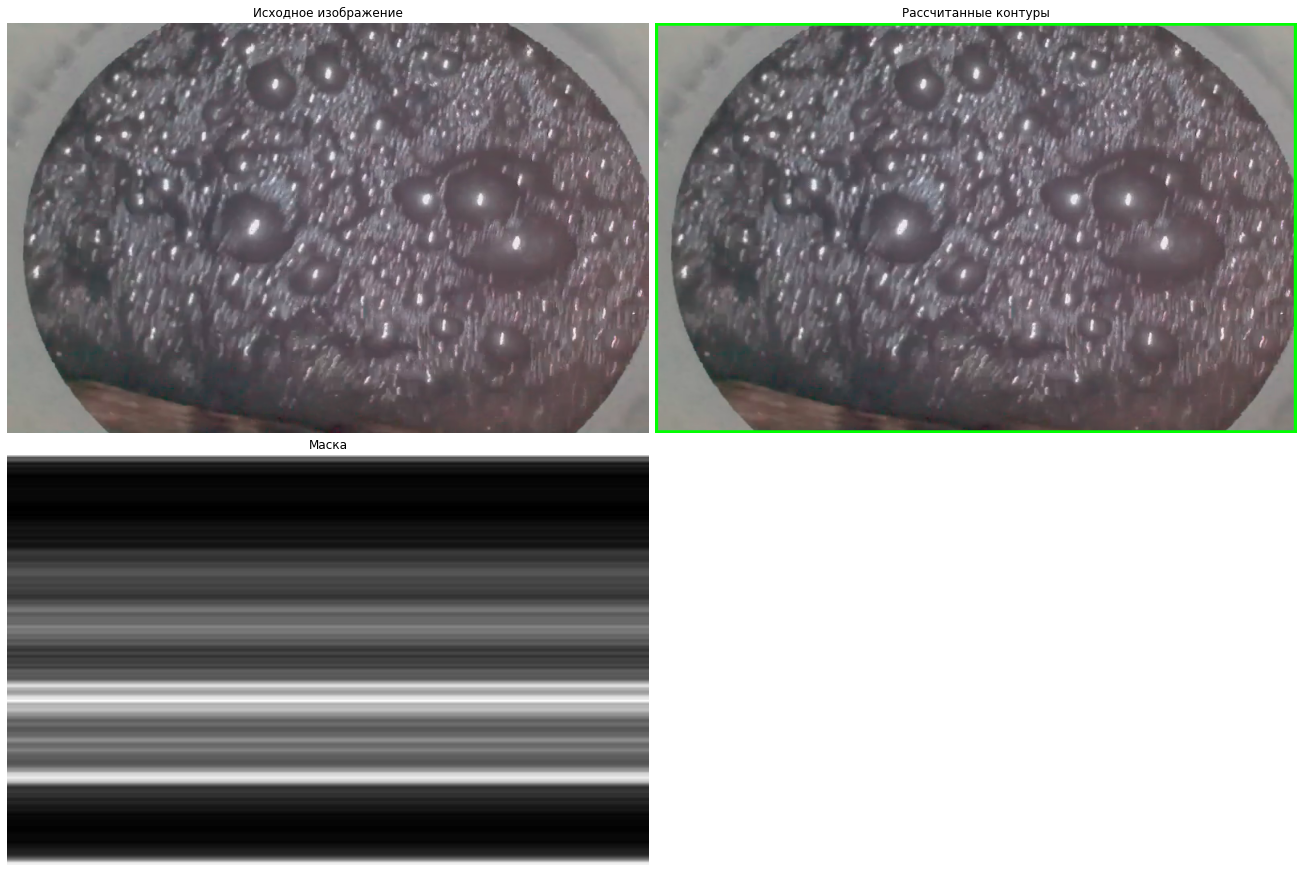

In [4]:
main()